#### This script is built on https://github.com/gpuhackathons-org/gpubootcamp/tree/78e9fee3432b60348489682a978fa63f29f7e839/hpc_ai/ai_science_cfd/English/python/jupyter_notebook/CFD

In [1]:
# Importing Necessary Libraries 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import importlib
import os
import h5py
from matplotlib import cm


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2021-12-06 21:36:01.838561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 21:36:04.693092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 21:36:04.805669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 21:36:04.806540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10421780533839498174,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11326455808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1531447900493098700
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [3]:
### restore data array from byte string
def parse_flow_data(serialized_example):
    parse_dic = {
    'boundary': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
    'v': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
    }
    example_message = tf.io.parse_single_example(serialized_example, parse_dic)

    boundary = example_message['boundary'] # get byte string
    v = example_message['v'] # get byte string

    boundary = tf.io.parse_tensor(boundary, out_type=tf.float64) # restore 2D array from byte string
    v = tf.io.parse_tensor(v, out_type=tf.float64) # restore 2D array from byte string

    
    boundary = tf.cast(boundary,dtype=tf.float32)
    v = tf.cast(v,dtype=tf.float32)

    return boundary,v

In [4]:
batch_size = 20

train_size = 1130
validation_size= 385
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

training_file=r"CNN_data/data_cnn_256_128_normalized.tfrecords"
validation_file=r"CNN_data/data_cnn_256_128_normalized_val.tfrecords"


def init_datasets():
    training_dataset = tf.data.TFRecordDataset(training_file)
    # Transform binary data into image arrays
    training_dataset = training_dataset.map(parse_flow_data)
    
    training_dataset = training_dataset.shuffle(buffer_size=100)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = tf.data.TFRecordDataset(training_file)
    # Transform binary data into image arrays
    validation_dataset = validation_dataset.map(parse_flow_data)    
    validation_dataset = validation_dataset.shuffle(buffer_size=100)
    validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()
    return training_dataset, validation_dataset

training_dataset, validation_dataset = init_datasets()


In [3]:
### loss function

def loss_image(vflow_hat, vflow):

    squared_difference = tf.square(vflow - vflow_hat)

    loss = tf.reduce_mean(squared_difference) 
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

## CNN-binary

In [8]:
def conv(input):
    # Define layers to calculate the convolution and FC part of the network
    # Arguments:
    # input -- (?, nh, nw, nc)
    #              128,256,1
    # Returns: (? 1,1,1024)
    
    x = layers.Conv2D(128, (4,4), strides=(4,4), padding='same', name='conv1', activation='relu')(input)
    x = layers.Conv2D(256, (4,4), strides=(4,4), padding='same', name='conv2', activation='relu')(x)   
    x = layers.Conv2D(512, (4,4), strides=(4,4), padding='same', name='conv3', activation='relu')(x)
    x = layers.Flatten()(x)
    
    lamda = 0
    ### Add a denslayer with ReLU activation
    x = layers.Dense(1024,bias_regularizer=tf.keras.regularizers.l2(lamda),kernel_regularizer=tf.keras.regularizers.l2(lamda), activation='relu')(x)    
    # Reshape the output as 1x1 image with 1024 channels:
    x = layers.Reshape((1,1,1024))(x)
    
    return(x)

def deconv(input, suffix):
    # Define layers that perform the econv steps
    # Arguments:
    # input -- (?, 1, 1, 1024)
    # suffix -- name_suffix
    # Returns -- (?,128,256,1)
    x = layers.Conv2DTranspose(512, (8,8), strides=(8,8), activation='relu', name="deconv1_"+suffix)(input)
    ###(8,8,512)
    
    ### Add the 2nd and 3rd Conv2DTranspose layers
    x = layers.Conv2DTranspose(256, (8,4), strides=(8,4), activation='relu', name="deconv2_"+suffix)(x)
    
    ###(64,32,256)
    
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', name="deconv3_"+suffix)(x)
    ###(128,64,32)
    
    x = layers.Conv2DTranspose(1, (2,2), strides=(2,2), activation='linear', name="deconv4_"+suffix)(x)
    ###(256,128,1)
    
    x = layers.Permute((2,1,3))(x)
    ###(128,256,1)
    return x

def conv_deconv(input):
    # Combine the convolution / deconvolution steps
    x = conv(input)
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, input])
    
     
    ### Add decoder for vy
    vy = deconv(x, "vy")
    ### 
    
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, input])
    
    
    ### Add decoder for vy
    h = deconv(x, "h")
    ### 
    
    h = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_h')([h, input])
    
    
    output = layers.concatenate([vx, vy, h], axis=3)
    
    return output

In [9]:
##Build model
K.clear_session()

# we need to re-init the dacaset because of Clearing our session
training_dataset, validation_dataset = init_datasets()

input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = conv_deconv(input)
conv_model = tf.keras.Model(inputs = input, outputs=output)

conv_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)

conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 128)  2176        boundary[0][0]                   
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 16, 256)   524544      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 2, 4, 512)    2097664     conv2[0][0]                      
______________________________________________________________________________________________

In [10]:
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)
import os
checkpoint_filepath = 'checkpoints_cnn_binary'

if not os.path.isdir(checkpoint_filepath):
        os.mkdir(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath,"points_check.hdf5"),
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    save_freq="epoch",
    mode='min',
    verbose=1,
)

In [12]:
##Train model
K.clear_session()
history = conv_model.fit(training_dataset, epochs=100, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches,shuffle = True,callbacks=[reduce_lr,model_checkpoint_callback])


56/56 [==============================] - 27s 480ms/step - loss: 0.5061 - val_loss: 0.3428

Epoch 00001: val_loss improved from inf to 0.34276, saving model to checkpoints_cnn_binary/points_check.hdf5


In [4]:
model_file =r"Trained_model/trained_cnn_binary.hdf5"
conv_model = tf.keras.models.load_model(model_file,custom_objects={'loss_image': loss_image})
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 128)  2176        boundary[0][0]                   
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 16, 256)   524544      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 2, 4, 512)    2097664     conv2[0][0]                      
______________________________________________________________________________________________

In [9]:
folderpath = r"triangular_pier_prediction_data\triangular_pier_binary"


filename = os.path.join(folderpath,"test_data.h5")

filename_boundary = os.path.join(folderpath,"boundary_data.csv")   #### Boundary coordinates for visualization

boundary= np.genfromtxt(filename_boundary,  delimiter=',', skip_header = 1)

n_rows_new = 128   #define number of rows (in y-direction)
n_cols_new = 256   #define number of colmuns (in x-direction)

stream_flow = h5py.File(filename)
stream_flow.keys()

vxy = stream_flow['Velocity_0']
vxy = np.array(vxy).reshape([1,n_rows_new,n_cols_new,3])
x = stream_flow['Gamma']
x = np.array(stream_flow["Gamma"]).reshape(1, n_rows_new, n_cols_new ,1)

vxy_hat = conv_model.predict(x)

x_sample_new=np.linspace(3,10,256)
y_sample_new=np.linspace(0,6,128)

x_grid_cnn,y_grid_cnn=np.meshgrid(x_sample_new,y_sample_new)

x_cnn=x_grid_cnn.flatten()
y_cnn=y_grid_cnn.flatten()

### The outputs was normalized in the training. Here de-normalized the prediction.
vflow_reverse = np.zeros(vxy_hat.shape)
vflow_reverse[0,:,:,0]=vxy_hat[0,:,:,0]*0.26+0.94
vflow_reverse[0,:,:,1]=vxy_hat[0,:,:,1]*0.14
vflow_reverse[0,:,:,2]=vxy_hat[0,:,:,2]*0.027+2

u_field_cnn=((vflow_reverse[0,:,:,0])).flatten()
v_field_cnn=((vflow_reverse[0,:,:,1])).flatten()
h_field_cnn=((vflow_reverse[0,:,:,2])).flatten()

Text(-5, 1.68, '$u$ (m/s)')

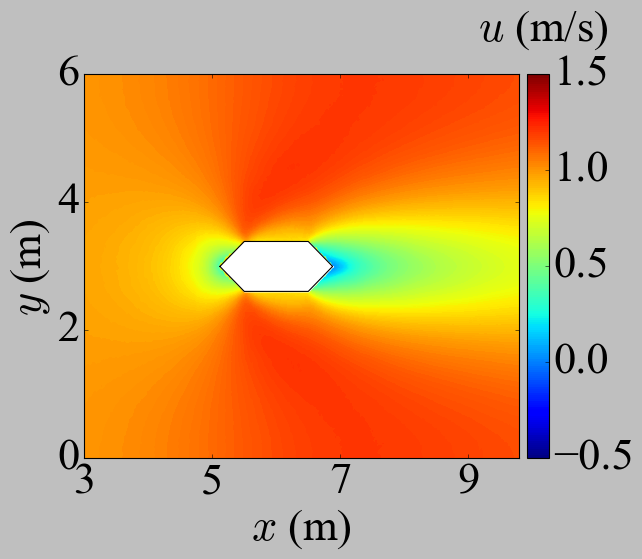

In [13]:
import matplotlib
plt.style.use("classic")
#matplotlib.font_manager._rebuild()
plt.rcParams['font.size'] = 40
plt.rcParams['font.family'] = 'Times New Roman'
axis_font = {'fontname':'Times New Roman', 'size':'14'}

fig = plt.figure(figsize = (10,6)) 

boundary_new = np.append(boundary,boundary[0,:])
boundary_new=boundary_new.reshape(len(boundary)+1,2)
boundary_plot_line=np.ones(boundary_new[:,1].shape)*3


plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.xlim([3.8,9.8])
plt.ylim([0.2,5.8])
cf=plt.contourf(x_grid_cnn,y_grid_cnn,u_field_cnn.reshape(128,256),100, cmap=cm.jet,levels=np.arange(-0.5,1.51,0.01))
plt.plot(boundary_new[:,0],boundary_new[:,1],'-k',mfc = 'white')

ax = plt.gca()
ax.fill_between(boundary_new[:,0],boundary_new[:,1],boundary_plot_line,edgecolor='white',facecolor='white')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)   
cbar=fig.colorbar(cf,cax=cax,ticks=np.arange(-0.5,1.51,0.5))
ax.set_xticks(np.arange(3, 10.1, step=2))
ax.set_yticks(np.arange(0, 6.1, step=2))
plt.text(-5,1.68, '$u$ (m/s)', fontsize=40,color='k',zorder=2)



## CNN-sdf

In [5]:
batch_size = 20

train_size = 1130
validation_size= 385
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

training_file=r"CNN_data/data_ann_256_128_normalized_sdf.tfrecords"
validation_file=r"CNN_data/data_ann_256_128_normalized_sdf_val.tfrecords"

def init_sdf_datasets():
    training_dataset = tf.data.TFRecordDataset(training_file)
    # Transform binary data into image arrays
    training_dataset = training_dataset.map(parse_flow_data)
    
    training_dataset = training_dataset.shuffle(buffer_size=100)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = tf.data.TFRecordDataset(training_file)
    # Transform binary data into image arrays
    validation_dataset = validation_dataset.map(parse_flow_data)
    
    validation_dataset = validation_dataset.shuffle(buffer_size=100)
    validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()
    return training_dataset, validation_dataset

training_dataset, validation_dataset = init_sdf_datasets()


In [18]:
def conv_deconv_sdf(input):
    # Combine the convolution / deconvolution steps
    boundary = layers.Lambda(lambda x : x[:,:,:,0:1], name="boundary_slice")(input)
    sdf = layers.Lambda(lambda x : x[:,:,:,1:2], name="sdf_slice")(input)
    
    
    ### Calculate the encoding using the SDF
    x = conv(sdf)
    ###
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, boundary])
    
    vy = deconv(x, "vy")
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, boundary])
    
    ### Add decoder for h
    h = deconv(x, "h")
    ### 
    
    h = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_h')([h, boundary])
    
    
    output = layers.concatenate([vx, vy, h], axis=3)
    
    return output
    




In [19]:
##Build model
sdf_training_dataset, sdf_validation_dataset = init_sdf_datasets()

# Define Input Outputs and Train the Model
input = tf.keras.Input(shape=(128,256,2), name="boundary")
output = conv_deconv_sdf(input)
conv_sdf_model = tf.keras.Model(inputs = input, outputs=output)
conv_sdf_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
conv_sdf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 2) 0                                            
__________________________________________________________________________________________________
sdf_slice (Lambda)              (None, 128, 256, 1)  0           boundary[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 128)  2176        sdf_slice[0][0]                  
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 16, 256)   524544      conv1[0][0]                      
____________________________________________________________________________________________

In [20]:
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)
import os
checkpoint_filepath = 'checkpoints_cnn_sdf'

if not os.path.isdir(checkpoint_filepath):
        os.mkdir(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath,"points_check.hdf5"),
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    save_freq="epoch",
    mode='min',
    verbose=1,
)

In [21]:
##Train model
K.clear_session()
history = conv_sdf_model.fit(sdf_training_dataset, epochs=100, steps_per_epoch=train_batches,
          validation_data=sdf_validation_dataset, validation_steps=validation_batches,shuffle = True,callbacks=[reduce_lr,model_checkpoint_callback])



56/56 [==============================] - 29s 483ms/step - loss: 0.3462 - val_loss: 0.1833

Epoch 00001: val_loss improved from inf to 0.18332, saving model to checkpoints_cnn_sdf/points_check.hdf5


In [14]:
model_file =r"Trained_model/trained_cnn_sdf.hdf5"
conv_model = tf.keras.models.load_model(model_file,custom_objects={'loss_image': loss_image})
conv_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 2) 0                                            
__________________________________________________________________________________________________
sdf_slice (Lambda)              (None, 128, 256, 1)  0           boundary[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 128)  2176        sdf_slice[0][0]                  
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 16, 256)   524544      conv1[0][0]                      
____________________________________________________________________________________________

In [16]:
folderpath = r"triangular_pier_prediction_data\triangular_pier_sdf"


filename = os.path.join(folderpath,"test_data.h5")

filename_boundary = os.path.join(folderpath,"boundary_data.csv")   #### Boundary coordinates for visualization

boundary= np.genfromtxt(filename_boundary,  delimiter=',', skip_header = 1)

n_rows_new = 128   #define number of rows (in y-direction)
n_cols_new = 256   #define number of colmuns (in x-direction)

stream_flow = h5py.File(filename)
stream_flow.keys()

vxy = stream_flow['Velocity_0']
vxy = np.array(vxy).reshape([1,n_rows_new,n_cols_new,3])
x = stream_flow['Gamma']
x = np.array(stream_flow["Gamma"]).reshape(1, n_rows_new, n_cols_new ,2)

vxy_hat = conv_model.predict(x)

x_sample_new=np.linspace(3,10,256)
y_sample_new=np.linspace(0,6,128)

x_grid_cnn,y_grid_cnn=np.meshgrid(x_sample_new,y_sample_new)

x_cnn=x_grid_cnn.flatten()
y_cnn=y_grid_cnn.flatten()

### The outputs was normalized in the training. Here de-normalized the prediction.
vflow_reverse = np.zeros(vxy_hat.shape)
vflow_reverse[0,:,:,0]=vxy_hat[0,:,:,0]*0.26+0.94
vflow_reverse[0,:,:,1]=vxy_hat[0,:,:,1]*0.14
vflow_reverse[0,:,:,2]=vxy_hat[0,:,:,2]*0.027+2

u_field_cnn=((vflow_reverse[0,:,:,0])).flatten()
v_field_cnn=((vflow_reverse[0,:,:,1])).flatten()
h_field_cnn=((vflow_reverse[0,:,:,2])).flatten()

Text(-5, 1.68, '$u$ (m/s)')

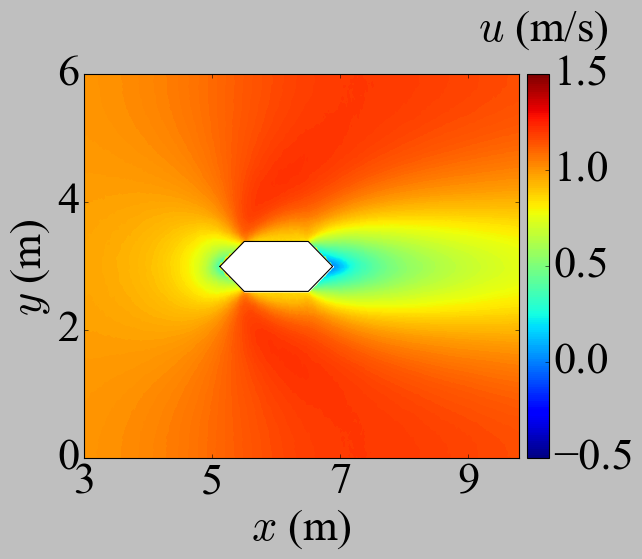

In [17]:
import matplotlib
plt.style.use("classic")
#matplotlib.font_manager._rebuild()
plt.rcParams['font.size'] = 40
plt.rcParams['font.family'] = 'Times New Roman'
axis_font = {'fontname':'Times New Roman', 'size':'14'}

fig = plt.figure(figsize = (10,6)) 

boundary_new = np.append(boundary,boundary[0,:])
boundary_new=boundary_new.reshape(len(boundary)+1,2)
boundary_plot_line=np.ones(boundary_new[:,1].shape)*3


plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.xlim([3.8,9.8])
plt.ylim([0.2,5.8])
cf=plt.contourf(x_grid_cnn,y_grid_cnn,u_field_cnn.reshape(128,256),100, cmap=cm.jet,levels=np.arange(-0.5,1.51,0.01))
plt.plot(boundary_new[:,0],boundary_new[:,1],'-k',mfc = 'white')

ax = plt.gca()
ax.fill_between(boundary_new[:,0],boundary_new[:,1],boundary_plot_line,edgecolor='white',facecolor='white')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)   
cbar=fig.colorbar(cf,cax=cax,ticks=np.arange(-0.5,1.51,0.5))
ax.set_xticks(np.arange(3, 10.1, step=2))
ax.set_yticks(np.arange(0, 6.1, step=2))
plt.text(-5,1.68, '$u$ (m/s)', fontsize=40,color='k',zorder=2)

